# Zyfra

Zyfra is a company, which develops efficiency solutions for the heavy industry.
Your task is to prepare a prototype of a Machine Learning model for Zyfra. <br>
The model must predict the amount of gold extracted from gold ore. You are provided with data from the extraction and purification processes.<br>
The model will help optimize production and eliminate unprofitable parameters.

You will need to:
- Prepare the data
- Perform data analysis
- Develop and train a model

## Data
The data are stored in three files:
- gold_recovery_train.csv
- gold_recovery_test.csv
- gold_recovery_full.csv

The data are indexed by the date and time of acquisition (date). <br>
Parameters that are close in time tend to be similar. <br>
Some parameters are not available because they were measured or calculated much later. As a result, some features present in the training set may be missing from the test set. The test set also does not contain target variables. <br>
The source dataset contains both the training and test sets with all features. <br>
You are provided with raw data that were downloaded directly from the data warehouse. Before building the model, verify that the data are correct by following the provided instructions. <br>

## Resources
- Gold Recovery Process: industrial-gold-recovery-prediction/assets/gold_recovery_process.png
- Technological Process: industrial-gold-recovery-prediction/notebooks/technological_process.ipynb
- Data Description: industrial-gold-recovery-prediction/notebooks/data_description.ipynb
- Recovery Calculation: industrial-gold-recovery-prediction/notebooks/recovery_calculation.ipynb

# 1. Inicialization

In [1]:
# Import functions
import sys
import os

sys.path.append(os.path.abspath('..'))

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from src.recovery import calculate_rougher_recovery
from src.null_columns import show_null_columns
from src.zero_columns import show_zero_columns
from src.metal_cols import clear_metal_columns
from src.col_over_time import missing_values_over_time
from src.rows_removal import remove_high_null
from src.plot_freq import plot_missing_result
from src.zeros_to_null import zeros_null

In [3]:
# Extract the info from the Datasets
#gold_train = pd.read_csv('/datasets/gold_recovery_train.csv') 
#gold_test = pd.read_csv('/datasets/gold_recovery_test.csv')

gold_train = pd.read_csv('C:\\Users\\gudia\\Repositories\\industrial-gold-recovery-prediction\\data\\raw\\gold_recovery_train.csv') 
gold_test = pd.read_csv('C:\\Users\\gudia\\Repositories\\industrial-gold-recovery-prediction\\data\\raw\\gold_recovery_test.csv')

### 1.1 Copy Original DataFrames

In [4]:
gold_train_clean =  gold_train.copy()
gold_test_clean = gold_test.copy()

### 1.2 Print Overview of Datasets

In [5]:
gold_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [6]:
gold_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

Findings: <br>
From the datasets, the column "rougher.output.recovery" represents the gold calculation recovery. <br>
Here, by using the function 'recovery' will help to determine if there's discrepancy between the data in column "rougher.output.recovery" and the result of the calculation using the function. <br>
This will be only in use of gold_train, as the df gold_test does not have this row.

### 1.3 Calculation Recovery
gold_train_clean

In [7]:
# Calculate recovery using the correct formula
calculated_recovery = calculate_rougher_recovery(gold_train_clean) 

# Compare with actual values (excluding NaN values)
mask = (calculated_recovery.notna() & gold_train_clean['rougher.output.recovery'].notna())
actual_recovery = gold_train_clean['rougher.output.recovery'][mask]
calc_recovery_clean = calculated_recovery[mask]

print(f"Valid data after filtering: {mask.sum()}")
print(f"    Total original data points: {len(gold_train_clean)}")
print(f"    Percentage of valid data: {(mask.sum() / len(gold_train_clean) * 100):.2f}%")
print()

print("First 5 actual vs calculated values:")
for i in range(5):
    print(
        f"  - Actual: {actual_recovery.iloc[i]:.4f}, "
        f"Calculated: {calc_recovery_clean.iloc[i]:.4f}"
    )
print()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_recovery, calc_recovery_clean)
print(f"Mean Absolute Error: {mae:.2f}")

Valid data after filtering: 14287
    Total original data points: 16860
    Percentage of valid data: 84.74%

First 5 actual vs calculated values:
  - Actual: 87.1078, Calculated: 87.1078
  - Actual: 86.8433, Calculated: 86.8433
  - Actual: 86.8423, Calculated: 86.8423
  - Actual: 87.2264, Calculated: 87.2264
  - Actual: 86.6888, Calculated: 86.6888

Mean Absolute Error: 0.00


Findings: <br>
For the recovery calculation, the columns related to the input and output of gold within the filtration process were taken into account. In this case, the following columns were used:

- rougher.output.concentrate_au
- rougher.input.feed_au
- rougher.output.tail_au

By analyzing these three columns and applying the recovery formula, a comparison was performed against the column rougher.output.recovery. This comparison was carried out using only valid (non-null) data, resulting in 84.74% of the training dataset being used for validation. <br>
<br>
From the printed comparison between the actual values and the calculated values, it can be observed that there is no difference between them. This result is confirmed by a Mean Absolute Error (MAE) of 0.00.
An MAE of zero indicates that the calculated values are identical to the actual values, confirming that the recovery data are consistent and correctly computed.

### 1.4 Features in the Test set
Here we review if there's a discrepancy between the columns in the train vs test set. <br>
This is critical to have aligned the columns so we can proceed with the modeling. 

In [8]:
# Review of common columns between gold_train and gold_test
common_cols = gold_train_clean.columns.intersection(gold_test_clean.columns)
print("Common columns:")
print(common_cols)

Common columns:
Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a

1. Considering the comparison between the columns of both datasets, the features that are missing in the test dataset but present in the training dataset are related to the following process stages:

    - final output (final output features)
    - primary_cleaner (primary purification)
    - rougher.calculation (flotation calculations)
    - rougher.output (flotation output)
    - secondary_cleaner (secondary purification)

2. These parameters do not appear in the test dataset because, according to the project instructions, they were measured or calculated much later in the process, after the flotation (rougher) and purification (cleaner) stages have been completed.

3. Performing this comparison is essential for future modeling, as we need symmetry between the training and test feature sets to ensure consistent and reliable model performance.

# 2. Data Preprocessing

### 2.1 gold_train

In [9]:
# General View
# print(gold_train_clean.sample(3))

# Adjusting datatype of column 'date' to datetime
gold_train_clean['date'] = pd.to_datetime(gold_train_clean['date'])

#### 2.1.1 Duplicate Values

In [10]:
print("the duplicate rows are:", gold_train_clean.duplicated().sum())  # Sum of Duplicated rows
print("the duplicate values in column 'date' are:", gold_train_clean['date'].duplicated().sum())  # Sum of Duplicated values

the duplicate rows are: 0
the duplicate values in column 'date' are: 0


#### 2.1.2 Null/Zero Values

In [11]:
show_null_columns(gold_train_clean)
show_zero_columns(gold_train_clean)


Columns with null values in Dataset:
                                   null_count  null_percent
rougher.output.recovery                  2573         15.26
rougher.output.tail_ag                   2250         13.35
rougher.output.tail_au                   2249         13.34
rougher.output.tail_sol                  2249         13.34
secondary_cleaner.output.tail_sol        1986         11.78

Columns with zero values in Dataset:
                                   zero_count  zero_percent
secondary_cleaner.output.tail_au         2298         13.63
secondary_cleaner.output.tail_sol        2298         13.63
secondary_cleaner.output.tail_ag         2298         13.63
secondary_cleaner.output.tail_pb         2298         13.63
final.output.tail_au                     1658          9.83


In [12]:
"""
Findings:
Both the training and test datasets contain null values and zeros. 
To determine whether zeros represent valid measurements or missing data, metal concentration columns were analyzed within their industrial context.
- Exact concentration values of 0.0 are physically unlikely in mining operations.
- Multiple metals showing 0.0 simultaneously suggests measurement issues.
- Sensor disconnections or process shutdowns are more plausible explanations than true zero concentrations.
These patterns indicate potential sensor failures rather than real metal values.
Therefore, metal concentration features (ag, pb, au) are likely to introduce noise and require careful handling before modeling.
"""
# Replace zeros for null values, applied for metal-related columns
gold_train_clean, metal_columns = clear_metal_columns(gold_train_clean)
gold_train_clean = zeros_null(gold_train_clean, metal_columns)

# Confirm no zeros are in the dataset
rows_zeros_train = gold_train_clean[(gold_train_clean == 0).all(axis=1)]
total_sum_train = rows_zeros_train.to_numpy().sum()
print()
print(f"Number of rows with zeros in all columns:", total_sum_train)

Metal-related columns found:
- final.output.concentrate_ag
- final.output.concentrate_pb
- final.output.concentrate_au
- final.output.tail_ag
- final.output.tail_pb
- final.output.tail_au
- primary_cleaner.output.concentrate_ag
- primary_cleaner.output.concentrate_pb
- primary_cleaner.output.concentrate_au
- primary_cleaner.output.tail_ag
- primary_cleaner.output.tail_pb
- primary_cleaner.output.tail_au
- rougher.calculation.sulfate_to_au_concentrate
- rougher.calculation.floatbank10_sulfate_to_au_feed
- rougher.calculation.floatbank11_sulfate_to_au_feed
- rougher.calculation.au_pb_ratio
- rougher.input.feed_ag
- rougher.input.feed_pb
- rougher.input.feed_au
- rougher.output.concentrate_ag
- rougher.output.concentrate_pb
- rougher.output.concentrate_au
- rougher.output.tail_ag
- rougher.output.tail_pb
- rougher.output.tail_au
- secondary_cleaner.output.tail_ag
- secondary_cleaner.output.tail_pb
- secondary_cleaner.output.tail_au

Number of rows with zeros in all columns: 0


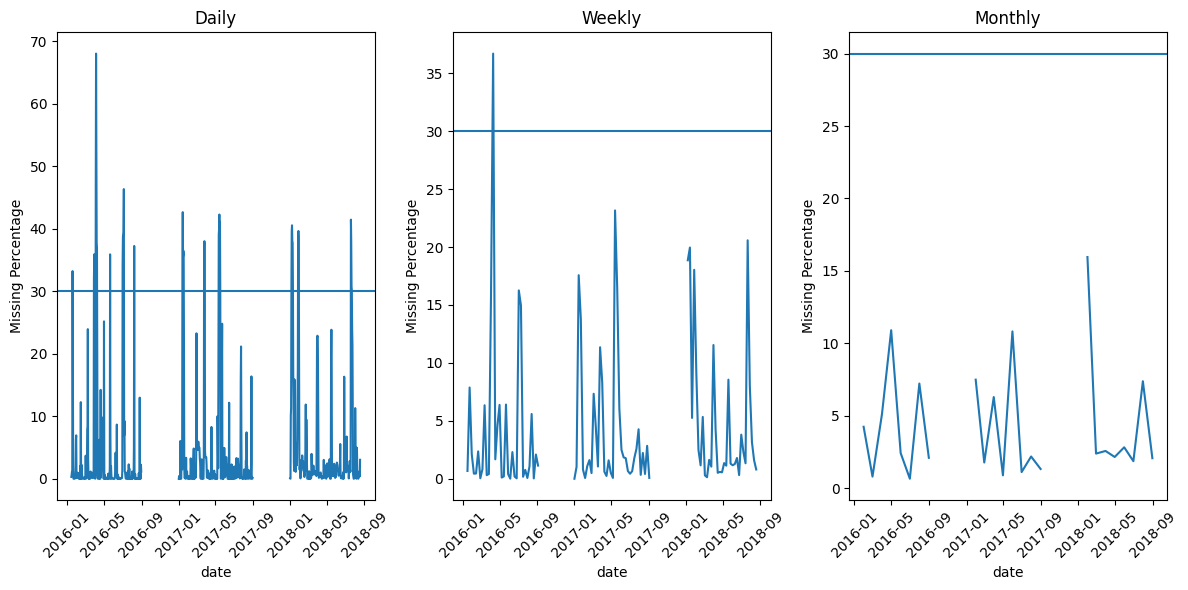

In [13]:
"""
Findings:
in the gold recovery context, the columns and rows along the dataset are critical. 
30% of data missingness along the rows is set as threshold to delete the rows, considering this threshold as safe limit before having 'noise' if we impute these rows. 
These rows can be due to:
- Shutdown periods
- Maintenance Windows
- Critical sensors not working properly

Now, to confirm this, i compared from different frequencies, looking for patterns that can help me to have more insight about the null values. 
"""
# Average percentage of missing values over time
gold_train_clean['percent'] = gold_train_clean.isnull().mean(axis=1) * 100
results_train = missing_values_over_time(gold_train_clean, 'date', 'percent')

# Plot the results
plot_missing_result(results_train)

In [14]:
# Remove rows above threshold
gold_train_clean = remove_high_null(gold_train_clean, 'percent', 30)

 - Cleaning statistics:
 - Original rows: 16,860
 - Removed rows: 1,157
 - Remaining rows: 15,703
 - Percentage removed: 6.86%


### 2.2 gold_test

In [15]:
# General View
# print(gold_test_clean.sample(3))

# Adjusting datatype of column 'date' to datetime
gold_test_clean['date'] = pd.to_datetime(gold_test_clean['date'])

#### 2.2.1 Duplicate Values

In [16]:
print("the duplicate rows are:", gold_test_clean.duplicated().sum())  # Sum of Duplicated rows
print("the duplicate values in column 'date' are:", gold_test_clean['date'].duplicated().sum())  # Sum of Duplicated values

the duplicate rows are: 0
the duplicate values in column 'date' are: 0


#### 2.2.2 Null/Zero Values

In [17]:
show_null_columns(gold_test_clean)
show_zero_columns(gold_test_clean)


Columns with null values in Dataset:
                                    null_count  null_percent
rougher.input.floatbank11_xanthate         353          6.03
primary_cleaner.input.sulfate              302          5.16
primary_cleaner.input.depressant           284          4.85
rougher.input.floatbank10_sulfate          257          4.39
primary_cleaner.input.xanthate             166          2.83

Columns with zero values in Dataset:
                                          zero_count  zero_percent
rougher.input.feed_ag                            369          6.30
rougher.input.feed_pb                            369          6.30
rougher.input.feed_au                            369          6.30
rougher.input.feed_sol                           369          6.30
secondary_cleaner.state.floatbank3_a_air         140          2.39


In [18]:
"""
Findings:
Both the training and test datasets contain null values and zeros. 
To determine whether zeros represent valid measurements or missing data, metal concentration columns were analyzed within their industrial context.
- Exact concentration values of 0.0 are physically unlikely in mining operations.
- Multiple metals showing 0.0 simultaneously suggests measurement issues.
- Sensor disconnections or process shutdowns are more plausible explanations than true zero concentrations.
These patterns indicate potential sensor failures rather than real metal values.
Therefore, metal concentration features (ag, pb, au) are likely to introduce noise and require careful handling before modeling.
"""
# Replace zeros for null values, applied for metal-related columns
gold_test_clean, metal_columns = clear_metal_columns(gold_test_clean)
gold_test_clean = zeros_null(gold_test_clean, metal_columns)

# Confirm no zeros are in the dataset
rows_zeros_test = gold_test_clean[(gold_test_clean == 0).all(axis=1)]
total_sum_test = rows_zeros_test.to_numpy().sum()
print()
print(f"Number of rows with zeros in all columns:", total_sum_test)

Metal-related columns found:
- rougher.input.feed_ag
- rougher.input.feed_pb
- rougher.input.feed_au

Number of rows with zeros in all columns: 0


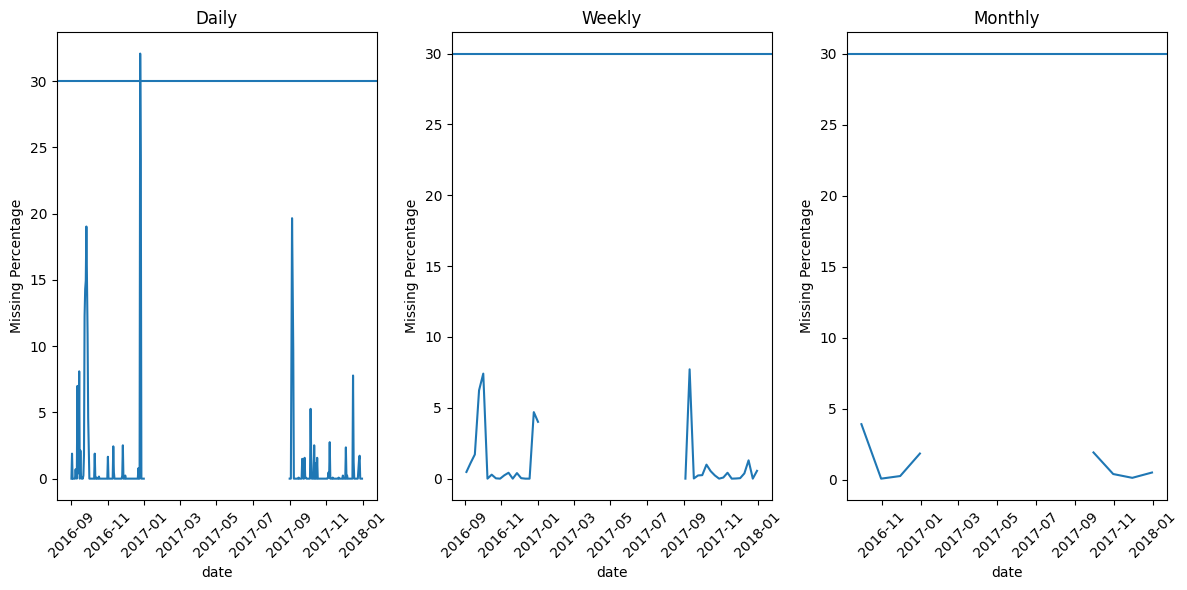

In [19]:
"""
Findings:
in the gold recovery context, the columns and rows along the dataset are critical. 
30% of data missingness along the rows is set as threshold to delete the rows, considering this threshold as safe limit before having 'noise' if we impute these rows. 
These rows can be due to:
- Shutdown periods
- Maintenance Windows
- Critical sensors not working properly

Now, to confirm this, i compared from different frequencies, looking for patterns that can help me to have more insight about the null values. 
"""
# Average percentage of missing values over time
gold_test_clean['percent'] = gold_test_clean.isnull().mean(axis=1) * 100
results_test = missing_values_over_time(gold_test_clean, 'date', 'percent')

# Plot the results
plot_missing_result(results_test)

In [20]:
# Remove rows above threshold
gold_test_clean = remove_high_null(gold_test_clean, 'percent', 30)

 - Cleaning statistics:
 - Original rows: 5,856
 - Removed rows: 16
 - Remaining rows: 5,840
 - Percentage removed: 0.27%
